### Lemon Quality Clustering - `ResNet50`

In this notebook we are going to use the [Lemon Quality Dataset](https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset) to do lemon segmentation on the lemon images.


For the dataset we are going to use the one that was obtained from kaggle:

> Dataset: https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset


First we are going to start by installing the packages that we are going to use in this notebook.

In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 6.7 MB/s eta 0:00:00


First we are going to import all the packages that we are going to use in this notebook.

In [59]:
import torch
import random
import time
import os
import copy
import shutil
import numpy as np
import warnings
import json

import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd


from torch.nn import functional as F
from torchvision import transforms
from torch.utils import data
from torchvision import models
from sklearn import decomposition, manifold
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from tqdm import tqdm
from uuid import uuid4
from PIL import Image
from helperfns.tables import tabulate_data

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

torch:  2.6.0+cu124
numpy:  2.0.2
pandas:  2.2.2


### Dataset

First we are going to start by downloading the dataset from kaggle using the kaggle api as follows:

> https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset

In [5]:

with open('kaggle.json', 'r') as reader:
  keys = json.loads(reader.read())
  os.environ['KAGGLE_USERNAME'] = keys['username']
  os.environ['KAGGLE_KEY'] = keys['key']

!kaggle datasets download yusufemir/lemon-quality-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset
License(s): CC0-1.0
 91% 211M/233M [00:00<00:00, 558MB/s]
100% 233M/233M [00:00<00:00, 581MB/s]


In the following code cell we are going to move all the images in different split sets to a single `images` folder.

In [6]:
DATABASE_IMAGES = "images"
if os.path.exists(DATABASE_IMAGES):
    shutil.rmtree(DATABASE_IMAGES)

if not os.path.exists(DATABASE_IMAGES):
    os.makedirs(DATABASE_IMAGES)

print("Done!")

Done!


First we are going to start by moving the images in the `check` directory to the `images` directory. We are only going to take the good and `bad` quality images and leave other images out since they don't contain lemons.

In [9]:
IMAGES_PATH = "lemon_dataset"
for class_ in ['bad_quality', 'good_quality']:
    class_folder = os.path.join(IMAGES_PATH, class_)
    for image in tqdm(os.listdir(class_folder)):
        new_name = f"{uuid4().hex}.{image.split('.')[-1]}"
        shutil.copy(os.path.join(class_folder, image), os.path.join(
            DATABASE_IMAGES, new_name
        ))

100%|██████████| 1125/1125 [00:00<00:00, 5343.16it/s]


### Seed

We are going to set the seed for all random operations in the following code cell for reproducivity in this notebook.

In [10]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Device

We are going to check if we will have access to a `GPU` for speed mathemetical computations

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### ResNet50

In the following code cell we are going to download the pretrained model.

In [12]:
resnet50 = models.resnet50(weights = True).to(device)
resnet50

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet model output `1000` different classes. We are going to finetune the last layer of our model so that it output a vector of dimention `10` insteard of `1000`.

In [13]:
IN_FEATURES = resnet50.fc.in_features
OUTPUT_DIM = 10
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
fc

Linear(in_features=2048, out_features=10, bias=True)

In the following code cell we are modifying the output layer of the `ResNet50` so that it output the vector dimension we desire.

In [14]:
resnet50.fc = fc

In [17]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["resnet50", *count_trainable_params(resnet50)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+----------+--------------+------------------+
| MODEL    | TOTAL PARAMS | TRAINABLE PARAMS |
+----------+--------------+------------------+
| resnet50 |   23,528,522 |       23,528,522 |
+----------+--------------+------------------+


### Image Transformations

In the following code cell we are going to create some image tranformation object, which will tranform the image for inference/testing for the expectations of the `ResNet50`. In our case for extracting features.

In [18]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
  transforms.Resize(pretrained_size),
  transforms.ToTensor(),
  transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
])

Next we are going to define a function that loads an image file to a tensor image.

In [19]:
def load_image(path):
    image = Image.open(path)
    return image_transforms(image)

In the following code cell we are going to create a helper function that will allow us to visualize some sample images in the dataset.

In [28]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

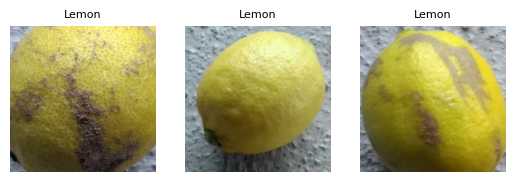

In [41]:
images  = [
    load_image(os.path.join(DATABASE_IMAGES, image_path)) for image_path in os.listdir(DATABASE_IMAGES)[:3]
]
for i, image in enumerate(images):
    plt.subplot(1, 3, i + 1)
    image = normalize_image(image)
    plt.imshow(image.permute(1, 2, 0))
    plt.title("Lemon", fontsize=8)
    plt.axis("off")
plt.show()

In the following code cell we are going to extract the features from the images using `resnet50`.

In [ ]:
def generete_vectors(model, device):
    model = model.to(device)
    model.eval()
    data = []
    with torch.no_grad():
        for image_path in tqdm(os.listdir(DATABASE_IMAGES)):
            image = load_image(os.path.join(DATABASE_IMAGES, image_path)).to(device).unsqueeze(0)
            vector = model(image).cpu().squeeze().numpy()
            data.append(vector)
    return np.array(data)
features = generete_vectors(resnet50, device)

 55%|█████▍    | 1133/2076 [04:35<03:40,  4.28it/s]

In [51]:
features.shape

(2076, 10)

In the next code cell we are going to use the `SpectralClustering` to cluster the legal doccuments into `3` different clusters.

In [79]:
N_CLUSTERS = 3
spectral = SpectralClustering(n_clusters=N_CLUSTERS, affinity='nearest_neighbors',
                              assign_labels='kmeans', random_state=SEED)
spectral_labels = spectral.fit_predict(features)

In the following code cell we are then going to evaluate the `SpectralClustering` on these text doccuments using different clustering metrics.

In [80]:
def evaluate_algorithms(algorithm, X, predicted_labels, true_labels=None):
  metrics = {
    "Silhouette Score": float(silhouette_score(X, predicted_labels)),
    "Davies-Bouldin Index": float(davies_bouldin_score(X, predicted_labels)),
    "Calinski-Harabasz Index": float(calinski_harabasz_score(X, predicted_labels))
  }
  if true_labels is not None:
    metrics["Mutual Info Score"] = mutual_info_score(true_labels, predicted_labels)
    metrics["Adjusted Rand Score"] = adjusted_rand_score(true_labels, predicted_labels)
  return metrics

metrics = evaluate_algorithms(spectral, features, spectral_labels)
metrics

{'Silhouette Score': 0.15330687165260315,
 'Davies-Bouldin Index': 2.0268556064344705,
 'Calinski-Harabasz Index': 287.1651916503906}

In [81]:
tabulate_data(["Metric", "Value"], [(k, f"{v:.3f}") for k, v in metrics.items()], title="Spectral Clustering Metrics")

Spectral Clustering Metrics
+-------------------------+---------+
| Metric                  |   Value |
+-------------------------+---------+
| Silhouette Score        |   0.153 |
| Davies-Bouldin Index    |   2.027 |
| Calinski-Harabasz Index | 287.165 |
+-------------------------+---------+


Next we are going to use the `TNSE` to do dimensinality reduction on the features before ploting clusters as follows:

In [68]:
X_reduced = TSNE(n_components=2, perplexity=30).fit_transform(features)

In the next code cell we are then going to plot our clusters and see what the model did.

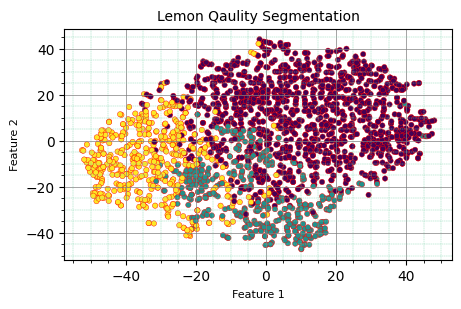

In [83]:
plt.figure(figsize=(5, 3))
scatter = plt.scatter(
    X_reduced[:, 0], X_reduced[:, 1], c=spectral_labels, cmap='viridis', s=15,  edgecolor="r", linewidths=0.3
)
plt.title("Lemon Qaulity Segmentation", fontsize=10)
plt.xlabel("Feature 1", fontsize=8)
plt.ylabel("Feature 2", fontsize=8)
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.minorticks_on()
plt.show()